In [34]:
import pandas as pd
import geopandas as gpd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='ticks', context='talk')
%matplotlib nbagg


In [58]:
intersection = gpd.read_file(r'J:\Geology\WSGS\GIS\elevation_intersection.shp') #reads in the hydraulic basin units and adds an area column
intersection = intersection.to_crs({'init': 'epsg:3732'})

In [66]:
possible_areas = intersection[((intersection['SURFACE'] == 'State') | (intersection['SURFACE'] == 'State (University of Wyoming)')
         |(intersection['SURFACE'] == 'State (Wyoming Game & Fish)') |(intersection['SURFACE'] == 'State (State Parks & Hist Sites)')
          |(intersection['SURFACE'] == 'Bureau of Land Management') |(intersection['SURFACE'] == 'Forest Service')) &
            intersection['gridcode'] == 1]

In [67]:
possible_areas.to_file(driver='ESRI Shapefile', filename='open_land_and_elevation.shp')


In [72]:
faults = gpd.read_file(r'J:\Geology\WSGS\GIS\Faults.shp') #reads in the hydraulic basin units and adds an area column
faults = faults.to_crs({'init': 'epsg:3732'})

<IPython.core.display.Javascript object>


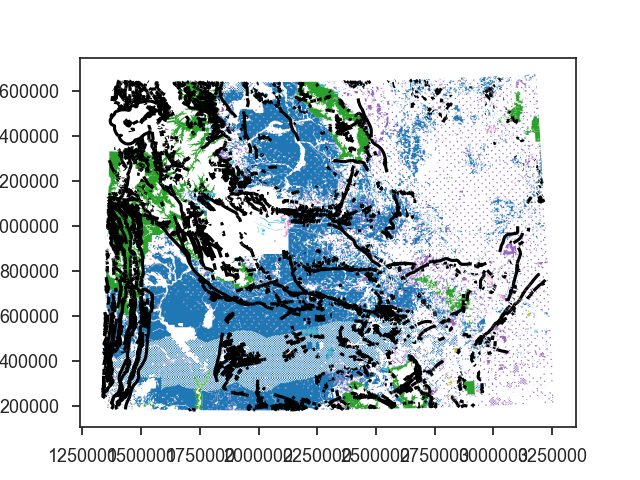

In [76]:
fig, ax = plt.subplots()
possible_areas.plot(column='SURFACE', ax=ax)
faults.plot(color='k', ax=ax)

<IPython.core.display.Javascript object>


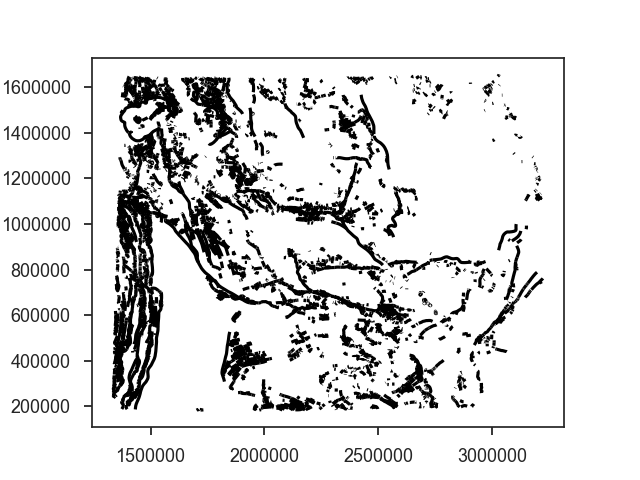

In [75]:
faults.plot(color='k')

In [74]:
faults.head()

,OBJECTID_1,OBJECTID,P1,CCA,BW,MAJOR1,MINOR1,DESCRIPT,RuleID,Shape_Leng,geometry
0,1,1.0,3,4,0,500.0,403.0,fault,4,0.007408,LINESTRING (1437531.050137461 1647097.92313242...
1,2,2.0,3,4,0,500.0,403.0,fault,4,0.031363,"LINESTRING (1451418.05543117 1634424.19644401,..."
2,3,3.0,3,4,0,500.0,403.0,fault,4,0.059701,LINESTRING (1436665.385989927 1626452.72642071...
3,4,4.0,3,4,0,500.0,403.0,fault,4,0.003682,LINESTRING (1432767.181914516 1644417.24548464...
4,5,5.0,3,4,0,500.0,403.0,fault,4,0.005848,"LINESTRING (1455293.78987431 1643157.22339501,..."
